### 在資料集上測試 (MVtech)
資料集: 
> THE MVTEC ANOMALY DETECTION DATASET (MVTEC AD)
> https://www.mvtec.com/company/research/datasets/mvtec-ad


<img src="https://www.mvtec.com/fileadmin/Redaktion/mvtec.com/company/research/datasets/dataset_overview_large.png" alt="drawing" width="400"/>

In [1]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential, layers
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from functools import partial
from IPython.display import display

from sklearn.model_selection import train_test_split


from unet import UNet
from utils import show_image_mask, mask_CutMix, patience


import albumentations as A
from albumentations import DualTransform
from typing_extensions import Concatenate
from typing_extensions import Concatenate

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
BATCH_SIZE = 16
NUM_LABELS = 1
WIDTH = 128
HEIGHT = 128
MULTI_CHANNELS = False

In [4]:
unet = UNet(num_class=1, padding = 'same', retain_dim=(WIDTH,HEIGHT))
x = np.zeros((1, HEIGHT, WIDTH, 3), dtype=np.float32)
y_pred = unet(x)
y_pred.shape

del unet

2023-03-03 11:57:22.618134: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 11:57:23.260367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1
2023-03-03 11:57:23.758135: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


In [5]:
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

In [6]:
item = 'capsule'
path = os.getcwd()
img_dir = f'{path}/data/{item}/test/scratch/'
print(len(os.listdir(img_dir)))
anno_dir = f'{path}/data/{item}/ground_truth/scratch/'

defective_number = [i.split('.')[0] for i in os.listdir(img_dir)]

23


### 取得image list
輸出: data_dic (字典)
- key: X_train, X_test, y_train, y_test

In [7]:
mask_dir = lambda anno_dir, X_lis:[anno_dir+i.split('.')[0]+'_mask.png' for i in X_lis]

imgs_path_list = sorted(os.listdir(img_dir))

size = 1/len(imgs_path_list)
size = 0.1
train, test = train_test_split(imgs_path_list, train_size = size)

key = 'X_train, X_test, y_train, y_test'.split(', ')

lis = []
for number in [train, test]:
    lis.append([img_dir+i for i in number]) # X
for number in [train, test]:
    lis.append(mask_dir(anno_dir, number)) # y
data_dic = dict(zip(key, lis))
data_dic['X_train']

['/home/jovyan/Course/CVCNN/Part6_UNet/data/capsule/test/scratch/012.png',
 '/home/jovyan/Course/CVCNN/Part6_UNet/data/capsule/test/scratch/011.png']

### Build dataset

In [8]:
def data_generater(imgs_path_list, anno_path_list, img_transform=None):
    for img_path in imgs_path_list:
        img_path = str(bytes.decode(img_path))
        file_name = img_path.split('/')[-1].split('.')[0]
        mask_path = [str(bytes.decode(i)) for i in anno_path_list if str(i).__contains__(file_name)][0]
        # cv2
        image = cv2.imread(img_path)
        image = np.array(image, dtype=np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE) # (1000, 1000) )
        mask = np.array(mask, dtype=np.float32)
        
        if img_transform == 1:
            transformed = transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        elif img_transform == 2:
            transformed = target_transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        image = tf.constant(image)

        mask = tf.constant(mask)
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = mask/255.
        yield image, mask



### BCE_with_logit
*二元分類，只有一個channel的輸出的場合。*

In [9]:
assert not MULTI_CHANNELS, 'MULTI_CHANNELS should "not" set as True above'
NUM_LABELS = 1
activation = tf.keras.layers.ReLU()
model = UNet(num_class=NUM_LABELS, retain_dim=(WIDTH,HEIGHT), activation=activation)
'''
要在建立optimizer之前就把model的參數移到gpu裡面 
ref: https://pytorch.org/docs/stable/optim.html 
'''

model.compile(  #使用model.compile()方法来配置训练方法
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1), #使用SGD优化器，学习率为0.1
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), #配置损失函数
    metrics = ['sparse_categorical_accuracy'] #标注网络评价指标
)
criterion = tf.keras.layers.Activation(tf.nn.softmax_cross_entropy_with_logits)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

In [10]:
# unet = UNet(num_class=2, padding = 'same', retain_dim=(WIDTH, HEIGHT))
x = np.zeros((1, WIDTH, HEIGHT, 3), dtype=np.float32)
y_pred = model(x)
print(y_pred.shape)

(1, 128, 128, 1)


In [11]:
x.shape

(1, 128, 128, 3)

### CE
交叉熵誤差，用於有多個channel的輸出的場合。

In [12]:
print('MULTI_CHANNELS should set as True above')
if MULTI_CHANNELS:
    NUM_LABELS = 1
    activation = tf.keras.layers.Activation('sigmoid')
    model = UNet(num_class=NUM_LABELS, retain_dim=(WIDTH,HEIGHT), activation=activation)

    criterion = tf.keras.layers.Activation(tf.nn.softmax_cross_entropy_with_logits)
    # criterion = DiceLoss()
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

MULTI_CHANNELS should set as True above


In [13]:
MULTI_CHANNELS

False

### 使用 albumentations 進行資料擴增

In [14]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
    A.CenterCrop(300, 900, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate((-30, 30), interpolation=0),  
    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([
    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

In [15]:
# 建議同時間只有16個(128,128)的sample進行計算 (Total = BATCH_SIZE*MULTIPLE_BATCH)
BATCH_SIZE = 16
MULTI_CHANNELS = False

# 在這邊會強制對所有不滿BATCH_SIZE的訓練資料做數量上的匹配，接著透過CustomImageDataset的transform做資料擴增
if len(data_dic['X_train']) < 16: 
    lis = data_dic['X_train']
    lis = [lis[i%len(lis)] for i in range(BATCH_SIZE)]
    data_dic['X_train'] = lis

train_ds = tf.data.Dataset.from_generator(data_generater,
                      output_signature=(tf.TensorSpec(shape=(None,None,3), dtype=tf.float32),
                      tf.TensorSpec(shape=(None,None,1), dtype=tf.float32)),
                      args=[data_dic['X_train'], data_dic['y_train'], 1])
test_ds = tf.data.Dataset.from_generator(data_generater,
                      output_signature=(tf.TensorSpec(shape=(None,None,3), dtype=tf.float32),
                      tf.TensorSpec(shape=(None,None,1), dtype=tf.float32)),
                      args=[data_dic['X_train'], data_dic['y_train'], 2]) # **如果要正式使用要記得把這裡換成X_test

dataset_train = train_ds.batch(BATCH_SIZE)
dataset_test = test_ds.batch(BATCH_SIZE)

In [16]:
for batch in dataset_train.take(1):
    print(f'{len(batch)}, {batch[0].shape}, {batch[1].shape}')

2, (16, 128, 128, 3), (16, 128, 128, 1)


#### 補充: 如何從dataset抽image, mask出來

(128, 128, 3)


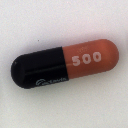

(128, 128, 3)


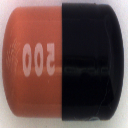

(128, 128, 3)


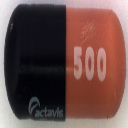

(128, 128, 3)


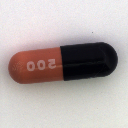

(128, 128, 3)


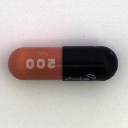

(128, 128, 3)


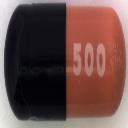

(128, 128, 3)


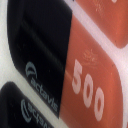

(128, 128, 3)


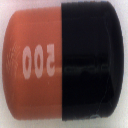

(128, 128, 3)


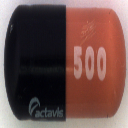

(128, 128, 3)


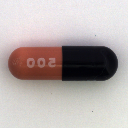

(128, 128, 3)


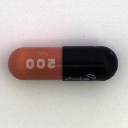

(128, 128, 3)


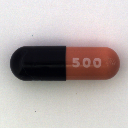

(128, 128, 3)


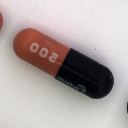

(128, 128, 3)


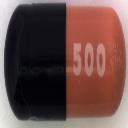

(128, 128, 3)


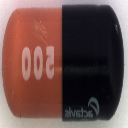

(128, 128, 3)


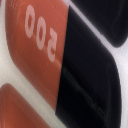

(128, 128, 1)


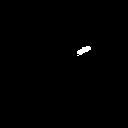

(128, 128, 1)


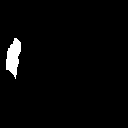

(128, 128, 1)


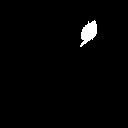

(128, 128, 1)


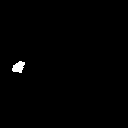

(128, 128, 1)


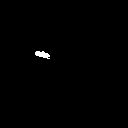

(128, 128, 1)


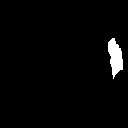

(128, 128, 1)


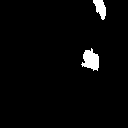

(128, 128, 1)


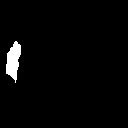

(128, 128, 1)


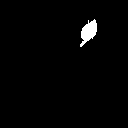

(128, 128, 1)


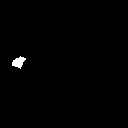

(128, 128, 1)


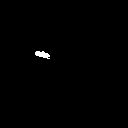

(128, 128, 1)


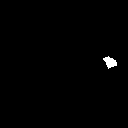

(128, 128, 1)


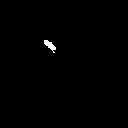

(128, 128, 1)


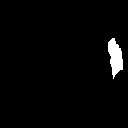

(128, 128, 1)


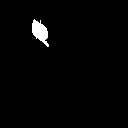

(128, 128, 1)


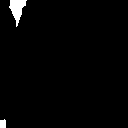

In [17]:
for batch in dataset_train.take(1):
    for img in batch[0]:
        print(img.shape)
        display(array_to_img(img))
    for img in batch[1]:
        print(img.shape)
        display(array_to_img(img))
    break

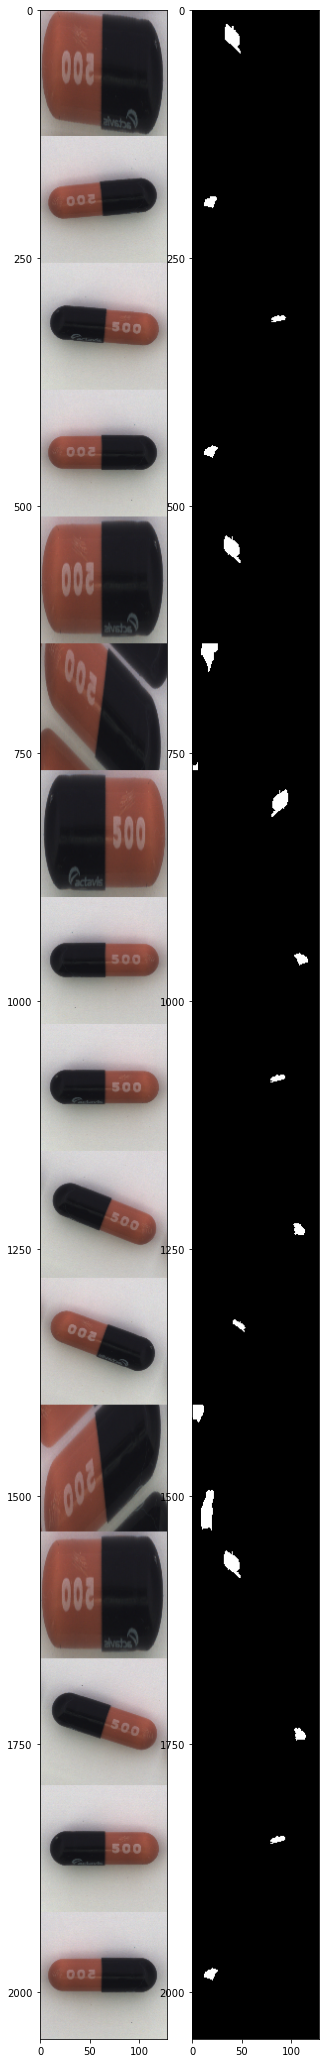

In [18]:
for image, mask in dataset_train.take(1):
    show_image_mask(image, mask)

# 訓練模型

In [19]:
model.compile(optimizer='adam',
       loss=[tf.keras.losses.sparse_categorical_crossentropy],
       metrics=['accuracy'])

model.fit(dataset_train, batch_size = 16, epochs=500)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.9622
Epoch 2/500
1/1 [==============================] - 1s 871ms/step - loss: nan - accuracy: 0.9873
Epoch 3/500
1/1 [==============================] - 1s 866ms/step - loss: nan - accuracy: 0.9865
Epoch 4/500
1/1 [==============================] - 1s 864ms/step - loss: nan - accuracy: 0.9857
Epoch 5/500
1/1 [==============================] - 1s 923ms/step - loss: nan - accuracy: 0.9876
Epoch 6/500
1/1 [==============================] - 1s 921ms/step - loss: nan - accuracy: 0.9886
Epoch 7/500
1/1 [==============================] - 1s 853ms/step - loss: nan - accuracy: 0.9876
Epoch 8/500
1/1 [==============================] - 1s 918ms/step - loss: nan - accuracy: 0.9887
Epoch 9/500
1/1 [==============================] - 1s 931ms/step - loss: nan - accuracy: 0.9885
Epoch 10/500
1/1 [==============================] - 1s 855ms/step - loss: nan - accuracy: 0.9841
Epoch 11/500
1/1 [========================